# Backend

## Crime Analysis Dashboard App

In [1]:
%pip install requests pandas numpy geopandas shapely mapbox-earcut


Note: you may need to restart the kernel to use updated packages.


In [76]:
#Import Libraries
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.ops import triangulate
from shapely.geometry import Polygon
import mapbox_earcut as earcut
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [3]:
police_forces = ["bedfordshire"]

## Get Police Force Table

In [4]:

def get_forces():

    """ 
    
    Defines the function to call the API and retrieve the police forces data table.
    
    Input: None.
    
    Output: Dataframe containing all the police forece ids and names.
    
    """

    # Defines the connection to the API
    url = "https://data.police.uk/api/forces"
    response = requests.get(url)

    # Raises exception if connection fails
    if response.status_code != 200:                                 
        raise Exception(f"API error: {response.status_code}")           
    
    # Converts responce to json
    data = response.json()

    # Converts json to dataframe
    df = pd.DataFrame(data)

    # Rename ID and name columns
    df.rename(columns={"id": "police_force_id", "name": "police_force_name"}, inplace=True)

    # Returns dataframe
    return df

# Defines the police force dataframe
df_forces = get_forces()

df_forces.sample(5)

,police_force_id,police_force_name
33,south-yorkshire,South Yorkshire Police
0,avon-and-somerset,Avon and Somerset Constabulary
8,devon-and-cornwall,Devon & Cornwall Police
21,leicestershire,Leicestershire Police
9,dorset,Dorset Police


## Get Neighbourhood Table

In [5]:

def get_neighbourhood(id):

    """

    Defines the function to call the API and retrieve the neighbourhood data table.

    Input: Police force ID.

    Output: Dataframe containing the neighbouthood id, name and which police force id it belongs to.

    """

    # Defines the connection to the API
    url = f"https://data.police.uk/api/{id}/neighbourhoods"     # Defines the API url 
    response = requests.get(url)                                # Defines the responce after we 'get' the url
    
    # Raises exception if connection fails
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}")
    
    # Converts responce to json 
    data = response.json()

    # Converts json to dataframe
    df = pd.DataFrame(data)

    # Adds police force ID
    df['police_force_id'] = id

    # Renames the ID and name columns
    df.rename(columns={"id": "neighbourhood_id", "name": "neighbourhood_name"}, inplace=True)

    # Returns dataframe
    return df

def get_all_neighbourhoods(police_forces):

    """

    Defines the function to get all neighbourhoods for a list of police forces.

    Input: List of police force IDs.

    Output: Dataframe containing all neighbourhoods for the given police forces.

    """

    # Empty list of neighbourhood dataframes 
    df_neighbourhoods_list =[]

    # Appends each neighbourhood dataframe to the list
    for id in police_forces:
        df_neighbourhoods_list.append(get_neighbourhood(id))

    # Unions the list of dataframes into one
    df_neighbourhoods = pd.concat(df_neighbourhoods_list)

    # Returns dataframe
    return df_neighbourhoods

df_neighbourhoods = get_all_neighbourhoods(police_forces).sample(5)

## Get Street-Level Crimes Table

In [6]:
def get_kml(neighbourhood_id): 
    
    """

    Defines the function to call the API and retrieve the neighbourhood KML file.

    Input: Neighbourhood ID.

    Output: Corresponding KML file content.
    
    """

    # Get pathfile from neighbourhood ID
    return f"C:/Users/Paul/Downloads/{neighbourhood_id}.kml"

    # Return KML content
    return path




def get_street_level_crimes(poly_str):

    """
    
    Defines the function to call the API and retrieve the neighbourhood boundaries data table.

    Input: A polygon string defining the area to get street-level crimes for.

    Output: Street-level crime dataframe for the neighbourhood.

    """

    # Defines the connection to the API
    url = f"https://data.police.uk/api/crimes-street/all-crime?poly={poly_str}"
    response = requests.get(url)
    
    # Raises exception if connection fails
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}")
    
    # Convert responce to json
    data = response.json()

    # Converts json to dataframe
    df = pd.DataFrame(data)

    # Returns dataframe
    return df



def load_polygon_from_kml(filepath):

    """

    A function to load a polygon from a KML file.

    Input: Filepath to the KML file.

    Output: Shapely polygon object.

    """

    # Loads KML file using geopandas
    gdf = gpd.read_file(filepath, driver="LIBKML")

    # Many KMLs contain a single feature
    polygon = gdf.geometry.iloc[0]

    # Returns polygon
    return polygon



def triangulate_polygon(polygon):

    """

    A function to triangulate a polygon into smaller triangles.

    Input: Shapely polygon object.

    Output: List of Shapely triangle objects.

    """

    # Triangulates polygon
    triangles = triangulate(polygon)

    # Keeps only triangles fully inside the polygon
    triangles = [t for t in triangles if polygon.contains(t.centroid)]

    # Returns list of triangles
    return triangles



def triangle_to_poly_string(triangle):
    
    """

    A function to convert a triangle to a polygon string.

    Input: Shapely triangle object.

    Output: Polygon string.

    """

    # Gets triangle coordinates
    coords = list(triangle.exterior.coords)[:-1]  # remove repeated closing point

    # convert (lng, lat) → (lat, lng)
    return ":".join(
        f"{coord[1]},{coord[0]}"
        for coord in coords
    )



def simplify_polygon(polygon, tolerance=0.0005):

    """

    Reduce polygon complexity while preserving shape.
    Tolerance ≈ 50m at UK latitudes.

    Input: Shapely polygon object, tolerance value.

    Output: Simplified Shapely polygon object.

    """

    # Simplifies polygon
    return polygon.simplify(tolerance, preserve_topology=True)



def process_kml_file_to_dataframe(police_force_id):

    """

    A function to process a KML file and retrieve street-level crime data for the area.

    Input: Filepath to the KML file.

    Output: Street-level crime dataframe for the area.

    """

    # Get KML filepath
    kml_path = get_kml(police_force_id)

    # Loads polygon
    polygon = load_polygon_from_kml(kml_path)

    # Simplifies polygon
    polygon = simplify_polygon(polygon)

    # Triangulates polygon
    triangles = triangulate_polygon(polygon)

    # Initialises a list to collect each triangle's dataframe
    all_dfs = []

    # Gets dataframa for each triangle
    for tri in triangles:
        
        # Converts the triangles to lists of coordiante strings
        poly_str = triangle_to_poly_string(tri)

        # Calls the API and gets the dataframe
        df = get_street_level_crimes(poly_str)

        # Combine dataframes
        all_dfs.append(df)

    # Checks that data has been collected, returns blank dataframe if no data is collected
    if len(all_dfs) == 0:
        return pd.DataFrame()

    # Combines all dataframes
    final_df = pd.concat(all_dfs, ignore_index=True)

    final_df["police_force_id"] = police_force_id

    # Returns combined dataframe
    return final_df



def get_crime_for_all_regions(police_forces):

    """ 

    A function to process KML files for all police forces and retrieve street-level crime data.

    Input: List of police force IDs.

    Output: Combined street-level crime dataframe for all police forces.

    """

    # Initialises a list to collect each police force's dataframe
    all_dfs = []

    # Gets dataframe for each police force
    for police_force_id in police_forces:
        df_crimes = process_kml_file_to_dataframe(police_force_id)

        # Add dataframe to list
        all_dfs.append(df_crimes)

    # Combines all dataframes
    final_df = pd.concat(all_dfs, ignore_index=True)

    # Returns combined dataframe
    return final_df



df_crimes = get_crime_for_all_regions(police_forces)
df_crimes.sample(5)



,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,police_force_id
1218,criminal-damage-arson,Force,"{'latitude': '51.880756', 'street': {'id': 194...",,"{'category': 'Under investigation', 'date': '2...",5d749bdc2bb307b3bae36bf133007b1fff8f2617315f7b...,131585718,,2025-10,bedfordshire
250,shoplifting,Force,"{'latitude': '52.193696', 'street': {'id': 194...",,{'category': 'Investigation complete; no suspe...,b8f538cffce3d34ab1f4cac481c34c32a2284e9629b652...,131584768,,2025-10,bedfordshire
2421,criminal-damage-arson,Force,"{'latitude': '52.145321', 'street': {'id': 194...",,"{'category': 'Unable to prosecute suspect', 'd...",83bb83696ac985c59e8bb870f2512a647c7edfe97ded2b...,131585688,,2025-10,bedfordshire
3278,violent-crime,Force,"{'latitude': '52.133330', 'street': {'id': 194...",,"{'category': 'Under investigation', 'date': '2...",3fce9617365a9009149a8360c42ca19f8cddd340742249...,131583733,,2025-10,bedfordshire
3008,violent-crime,Force,"{'latitude': '52.131310', 'street': {'id': 194...",,"{'category': 'Under investigation', 'date': '2...",416ad9801a94773a24289222f5ca4fbeaf1203ddfc3172...,131582489,,2025-10,bedfordshire


In [7]:
df_crimes.sample(5)

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,police_force_id
1367,shoplifting,Force,"{'latitude': '51.882741', 'street': {'id': 194...",,"{'category': 'Under investigation', 'date': '2...",a691a72bc30907ff369219979996415ddc1064004f7d38...,131584924,,2025-10,bedfordshire
1224,criminal-damage-arson,Force,"{'latitude': '51.887000', 'street': {'id': 194...",,{'category': 'Investigation complete; no suspe...,f3bdc1a993696ab4923d43fc43e2c557f882f6746b80ca...,131585587,,2025-10,bedfordshire
1392,theft-from-the-person,Force,"{'latitude': '51.878932', 'street': {'id': 194...",,{'category': 'Investigation complete; no suspe...,795fca7bde5ecedef7daddddeed99f56a3c8207b85163d...,131584593,,2025-10,bedfordshire
105,violent-crime,Force,"{'latitude': '52.268319', 'street': {'id': 194...",,"{'category': 'Under investigation', 'date': '2...",dea07cdca4f3804ae626c55b524dcca2604354a07a89b7...,131881334,,2025-10,bedfordshire
3260,violent-crime,Force,"{'latitude': '52.138251', 'street': {'id': 194...",,"{'category': 'Under investigation', 'date': '2...",526334f6b6fa588d1861daf82cec02ab8f9c6614a31b06...,131583443,,2025-10,bedfordshire


## Get Specific Neighbourhood Table

In [8]:
def get_specific_neighbourhood(police_force_id, neighbourhood_id):

    """

    A function to get data for a specific neighbourhood.

    Input: Police force ID. Neighbourhood ID.

    Output: Dataframe containing all data for the specific neighbourhood.


    """

    # Defines the connection to the API
    url = f"https://data.police.uk/api/{police_force_id}/{neighbourhood_id}"
    response = requests.get(url)
    
    # Raises exception if connection fails
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}")
    
    # Convert responce to json
    data = response.json()

    # Converts json to dataframe
    df = pd.json_normalize(data)

    # Returns dataframe
    return df
    
    
def get_specific_neighnourhoods_from_police_force(police_force_id, df_neighbourhoods=df_neighbourhoods):

    """

    A function to get all specific neighbourhoods for a police force ID.

    Input: Police force ID. Neighbourhoods dataframe.

    Output: Dataframe containing all neighbourhoods for the specific police force ID.

    """

    # Initiates empty list to collect dataframes
    specific_neighbourhood_list = []

    # Loops through all neighbourhood ID's for the specific police force ID
    for neighbourhood_id in df_neighbourhoods["neighbourhood_id"][df_neighbourhoods["police_force_id"] == police_force_id]:

        # Calls the API and gets the dataframe
        df = get_specific_neighbourhood(police_force_id, neighbourhood_id)

        # Appends dataframe to the list
        specific_neighbourhood_list.append(df)

    # Unions the list of dataframes into one
    df = pd.concat(specific_neighbourhood_list, ignore_index=True)

    # Adds police force ID column
    df["police_force_id"] = police_force_id

    # Returns datatframe
    return df



df_specific_neighbourhoods = get_specific_neighnourhoods_from_police_force("bedfordshire")
print(df_specific_neighbourhoods.head())



    id                                     name  \
0  NU4              Putnoe, Goldington, Newnham   
1  LU4                        Luton Town Centre   
2  CB2  Biggleswade, Sandy, Potton and Shefford   
3  NU1          Kingsbrook, Kempston, Cauldwell   
4  NU2                   Queens Park and Castle   

                                           url_force population links  \
0  https://www.police.uk/pu/your-area/bedfordshir...          0    []   
1  https://www.beds.police.uk/area/your-area/bedf...          0    []   
2  https://www.police.uk/pu/your-area/bedfordshir...          0    []   
3  https://www.police.uk/pu/your-area/bedfordshir...          0    []   
4  https://www.police.uk/pu/your-area/bedfordshir...          0    []   

  locations centre.latitude centre.longitude  \
0        []         52.1449         -0.42817   
1        []         51.8797        -0.414051   
2        []         52.0853        -0.274014   
3        []         52.1157        -0.467834   
4        []   

---

# Web Scraping Population Data


In [27]:
df_population = pd.read_csv("C:/Users/Paul/Downloads/population_data.csv")
df_population.head()

,police_force_id,population
0,thames-valley,2.4m
1,hertfordshire,1.2m
2,bedfordshire,0.682m
3,northamptonshire,0.757m


---

# Cleaning - Street Level Crime

In [11]:
df = df_crimes.copy()

In [12]:
df.isna().sum()

category              0
location_type         0
location              0
context               0
outcome_status      729
persistent_id         0
id                    0
location_subtype      0
month                 0
police_force_id       0
dtype: int64

## Filling Nulls

In [13]:
# Fills nulls in the outcome column with 'Unknown'
def fill_blank_outcome_status(df):

    """

    A function to fill blank outcome status values with 'Unknown'.

    Input: Crime dataframe.

    Output: Crime dataframe with filled outcome status values.

    """

    # Fills nulls in the outcome column with 'Unknown'
    df["outcome_status"] = df["outcome_status"].fillna("Unknown")

    # Returns dataframe
    return df


df = fill_blank_outcome_status(df_crimes)
df.isna().sum()

category            0
location_type       0
location            0
context             0
outcome_status      0
persistent_id       0
id                  0
location_subtype    0
month               0
police_force_id     0
dtype: int64

## Checking for Duplicates

In [14]:
def remove_duplicates(df):
    if "id" in df.columns:
        return df.drop_duplicates(subset=["id"]).reset_index(drop=True)

    subset = [c for c in ["latitude", "longitude", "month", "category"] if c in df.columns]
    return df.drop_duplicates(subset=subset).reset_index(drop=True)

df = remove_duplicates(df)
df.shape

(5112, 10)

## Check Datatypes


In [15]:
df.dtypes

category            object
location_type       object
location            object
context             object
outcome_status      object
persistent_id       object
id                   int64
location_subtype    object
month               object
police_force_id     object
dtype: object

# Separating Location Column

In [16]:
def extract_coordinates_and_street(df):

    """

    A function to extract latitude, longitude and street name from the location column.

    Input: Crime dataframe.

    Output: Crime dataframe with new latitude, longitude and street name columns.

    """

    # Extracts coordinates and street name from location column
    coords = pd.json_normalize(df["location"])
    df["latitude"] = pd.to_numeric(coords["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(coords["longitude"], errors="coerce")
    df["street_name"] = coords["street.name"]
    df.drop(columns=["location"], inplace=True)
    
    # Returns dataframe
    return df

df = extract_coordinates_and_street(df)
df.head()

,category,location_type,context,outcome_status,persistent_id,id,location_subtype,month,police_force_id,latitude,longitude,street_name
0,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,878958d357620bcede7814df7396bc02f2840dbf853050...,131584336,,2025-10,bedfordshire,52.276206,-0.602470,On or near Cambridge Street
1,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,8dbda9108ab2a2a9b4415d668d3c923a9c247db818ab92...,131584186,,2025-10,bedfordshire,52.276206,-0.602470,On or near Cambridge Street
2,vehicle-crime,Force,,"{'category': 'Unable to prosecute suspect', 'd...",70cc172375bb5e7a981e62388025ad381234cf564d626b...,131584139,,2025-10,bedfordshire,52.289054,-0.517686,On or near High Top Barns
3,vehicle-crime,Force,,"{'category': 'Under investigation', 'date': '2...",0b0a4b395eb20a8921a7d2f23536971bee0322aa0047c9...,131584218,,2025-10,bedfordshire,52.301284,-0.471285,On or near Shelton Road
4,burglary,Force,,{'category': 'Investigation complete; no suspe...,a70d901945b19e53e0030ada6f30c52e42ab746401fc48...,131584020,,2025-10,bedfordshire,52.208093,-0.270233,On or near Alington Road


## Separating Date Column

In [17]:
def extract_date_components(df):

    """

    A function to extract year and month from the month column.

    Input: Crime dataframe.

    Output: Crime dataframe with new year and month columns.

    """

    # Converts month column to datetime format
    df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

    # Extracts year and month from month column
    df["year"] = df["month"].dt.year
    df["month"] = df["month"].dt.month

    # Returns dataframe
    return df

df = extract_date_components(df)
df.head()

,category,location_type,context,outcome_status,persistent_id,id,location_subtype,month,police_force_id,latitude,longitude,street_name,year
0,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,878958d357620bcede7814df7396bc02f2840dbf853050...,131584336,,10,bedfordshire,52.276206,-0.602470,On or near Cambridge Street,2025
1,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,8dbda9108ab2a2a9b4415d668d3c923a9c247db818ab92...,131584186,,10,bedfordshire,52.276206,-0.602470,On or near Cambridge Street,2025
2,vehicle-crime,Force,,"{'category': 'Unable to prosecute suspect', 'd...",70cc172375bb5e7a981e62388025ad381234cf564d626b...,131584139,,10,bedfordshire,52.289054,-0.517686,On or near High Top Barns,2025
3,vehicle-crime,Force,,"{'category': 'Under investigation', 'date': '2...",0b0a4b395eb20a8921a7d2f23536971bee0322aa0047c9...,131584218,,10,bedfordshire,52.301284,-0.471285,On or near Shelton Road,2025
4,burglary,Force,,{'category': 'Investigation complete; no suspe...,a70d901945b19e53e0030ada6f30c52e42ab746401fc48...,131584020,,10,bedfordshire,52.208093,-0.270233,On or near Alington Road,2025


---

# Cleaning - Specific Neighbourhood

In [18]:
df_specific_neighbourhoods.sample(5)

,id,name,url_force,population,links,locations,centre.latitude,centre.longitude,contact_details.email,police_force_id
1,LU4,Luton Town Centre,https://www.beds.police.uk/area/your-area/bedf...,0,[],[],51.8797,-0.414051,LutonTC-CPT@beds.police.uk,bedfordshire
0,NU4,"Putnoe, Goldington, Newnham",https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],52.1449,-0.42817,CommunityNorthBedfordUrban@beds.police.uk,bedfordshire
2,CB2,"Biggleswade, Sandy, Potton and Shefford",https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],52.0853,-0.274014,BiggleswadeSPT@beds.police.uk,bedfordshire
4,NU2,Queens Park and Castle,https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],52.1363,-0.471572,CommunityNorthBedfordUrban@beds.police.uk,bedfordshire
3,NU1,"Kingsbrook, Kempston, Cauldwell",https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],52.1157,-0.467834,CommunityNorthBedfordUrban@beds.police.uk,bedfordshire


---

# Cleaning - Population Data 

In [28]:
def clean_population(pop):

    """

    A function to clean the population column.

    Input: Population.

    Output: Cleaned population.

    """

    # Removes m from population values
    pop = pop.replace("m", "")

    # Converts population to a float
    pop = float(pop)

    # Changes decimal to millions
    pop = pop * 1000000

    # Returns cleaned population
    return int(pop)


def clean_population_df(df_population):

    """

    A function to clean the population dataframe.

    Input: Population dataframe.

    Output: Cleaned population dataframe.

    """

    # Cleans population column
    df_population["population"] = df_population["population"].apply(clean_population)

    # Returns cleaned dataframe
    return df_population

df_population = clean_population_df(df_population)
df_population.head()

,police_force_id,population
0,thames-valley,2400000
1,hertfordshire,1200000
2,bedfordshire,682000
3,northamptonshire,757000


## Combining Cleaning into one Step

In [20]:
def cleaning(df):

    """

    A function to clean the crime dataframe.

    Input: Crime dataframe.

    Output: Cleaned crime dataframe.

    """

    # Fills blank outcome status values
    df = fill_blank_outcome_status(df)

    # Removes duplicate rows
    df = remove_duplicates(df)

    # Extracts latitude, longitude and street name
    df = extract_coordinates_and_street(df)

    # Extracts year and month from month column
    df = extract_date_components(df)

    # Returns cleaned dataframe
    return df

df_crimes = cleaning(df_crimes)

---

# Graphs

## Crime Rate by Region - Lollipop Chart


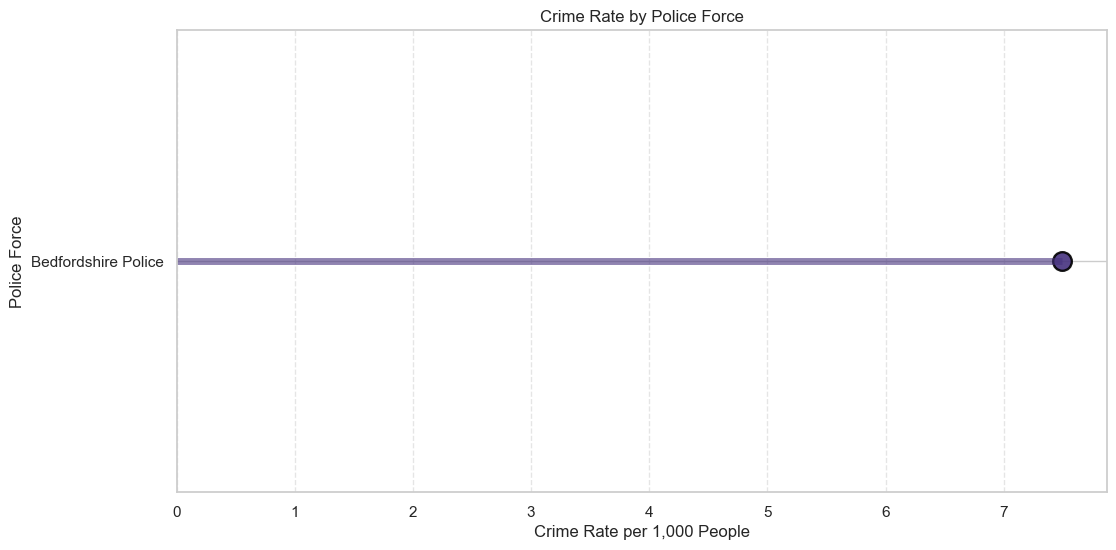

     police_force_name  crime_count  population  crime_rate_per_1000
0  Bedfordshire Police         5112      682000             7.495601


In [21]:

def add_crime_rate_column(df):

    """

    A function to calculate crime rate by region.

    Input: Dataframe with necessary columns for calculating crime rate by region.

    Output: Dataframe with crime rate by region.

    """

    

    # Calculates crime rate per 1,000 people
    df["crime_rate_per_1000"] = (df["crime_count"] / df["population"]) * 1000

    # Returns dataframe
    return df



def get_columns_for_crime_rate_by_region(df_crimes, df_population, df_forces):

    """

    A function to get the necessary columns for calculating crime rate by region.

    Input: Crime dataframe. Population dataframe. Police forces dataframe.

    Output: Dataframe with necessary columns for calculating crime rate by region.

    """

    # Groups crimes by region and counts number of crimes
    df_crime_counts = df_crimes.groupby("police_force_id").size().reset_index(name="crime_count")

    # Merges crime counts with population data
    df_merged_1 = pd.merge(df_crime_counts, df_population, on="police_force_id", how="left")

    # Merges crime counts and population data with police forces data
    df_merged_2 = pd.merge(df_merged_1, df_forces, on="police_force_id", how="left")

    # Selects necessary columns
    df_result = df_merged_2[["police_force_name", "crime_count", "population"]]

    # Adds crime rate column
    df_result = add_crime_rate_column(df_result)

    # Returns dataframe
    return df_result



def crime_rate_by_region_graph(df, theme = ["whitegrid", "viridis"]):

    """

    A function to create a lollipop chart of crime rate by region.

    Input: Dataframe with crime rate by region.

    Output: Lollipop chart.

    """

    # Set the theme for the plot
    sns.set_theme(style=theme[0], palette=theme[1])

    # Sort for nicer plotting
    df = df.sort_values("crime_rate_per_1000")

    plt.figure(figsize=(12, 6))

    # Draw stems (lines from 0 to value)
    plt.hlines(
        y=df["police_force_name"],
        xmin=0,
        xmax=df["crime_rate_per_1000"],
        linewidth=5,
        alpha=0.6
    )

    # Draw lollipop heads
    sns.scatterplot(
        x="crime_rate_per_1000",
        y="police_force_name",
        size="population",
        sizes=(180, 1200),
        data=df,
        legend=False,
        edgecolor="black",
        linewidth=1.7,
        alpha=0.9
    )

    plt.xlabel("Crime Rate per 1,000 People")
    plt.ylabel("Police Force")
    plt.title("Crime Rate by Police Force")
    plt.xlim(left=0)
    plt.grid(axis="x", linestyle="--", alpha=0.5)

    plt.show()



def crime_rate_by_region_info(df_crime_rate):

    """ 

    A function to display information about crime rate by region for the LLM.

    Input: Dataframe with crime rate by region.

    Output: String containing information about crime rate by region.

    """

    # Gets descriptive statistics
    info = df_crime_rate.to_string()

    # Returns information string
    return info


df_crime_rate = get_columns_for_crime_rate_by_region(df_crimes, df_population, df_forces)

crime_rate_by_region_graph(df_crime_rate)
print(crime_rate_by_region_info(df_crime_rate))

## Crime Rate over Time

In [22]:
def get_columns_for_crime_rate_over_time(df_crimes, df_population, df_forces, min_date="2022-01-01", max_date="2025-12-31"):

    """

    A function to get the necessary columns for calculating crime rate by region.

    Input: Crime dataframe. Population dataframe. Police forces dataframe.

    Output: Dataframe with necessary columns for calculating crime rate by region.

    """

    # Groups crimes by month and year and counts number of crimes
    df_crimes["date"] = pd.to_datetime(df_crimes[["year", "month"]].assign(day=1))
    df_filtered = df_crimes[(df_crimes["date"] >= min_date) & (df_crimes["date"] <= max_date)]

    # Count crimes by date and police force
    df_counts = (
        df_crimes
        .groupby(["date", "police_force_id"])
        .size()
        .reset_index(name="crime_count")
    )

    # Merge population
    df_counts = df_counts.merge(
        df_population,
        on="police_force_id",
        how="left"
    )

    # Merge force names
    df_counts = df_counts.merge(
        df_forces,
        on="police_force_id",
        how="left"
    )

    # Selects necessary columns
    df_result = df_counts[["date", "police_force_name", "crime_count", "population"]]

    df_result = add_crime_rate_column(df_result)

    # Returns dataframe
    return df_result

df = get_columns_for_crime_rate_over_time(df_crimes, df_population, df_forces)
print(df.head())

        date    police_force_name  crime_count  population  \
0 2025-10-01  Bedfordshire Police         5112      682000   

   crime_rate_per_1000  
0             7.495601  


## Crime Types against Police Force Heatmap

In [89]:
def get_columns_for_heatmap_table(df_crimes, df_population, df_forces):

    """

    A function to get the necessary columns for creating a heatmap.

    Input: Crime dataframe. Population dataframe. Police forces dataframe.

    Output: Dataframe with necessary columns for creating a heatmap.

    """
    

    # Groups crimes by police force and category and counts number of crimes
    df_crime_counts = df_crimes.groupby(["police_force_id", "category"]).size().reset_index(name="crime_count")

    # Merges crime counts with population data
    df_merged_1 = pd.merge(df_crime_counts, df_population, on="police_force_id", how="left")

    # Merges crime counts and population data with police forces data
    df_merged_2 = pd.merge(df_merged_1, df_forces, on="police_force_id", how="left")

    # Adds crime rate column
    df_merged_2 = add_crime_rate_column(df_merged_2)

    

    # Selects necessary columns
    df_result = df_merged_2[["police_force_name", "category", "crime_count", "population"]]

    # Adds crime rate column
    df_result = add_crime_rate_column(df_result)
    
    # Removes less overpowering categories
    df_result = df_result[~df_result["category"].isin(["violent-crime", "anti-social-behaviour"])]

    # Formats category names
    df_result["category"] = (df_result["category"].str.replace("-", " ").str.title())

    # Returns dataframe
    return df_result



def type_against_region_heatmap_graph(df, theme = ["whitegrid", "viridis"]):

    """

    A function to create a heatmap of crime categories by police force.

    Input: Dataframe with crime categories by police force.

    Output: Heatmap.

    """

    # Use pivot_table to avoid duplicate issues
    heatmap_data = df.pivot_table(
        index="category",
        columns="police_force_name",
        values="crime_count",
        aggfunc="sum",
        fill_value=0
    )

    fig = px.imshow(
        heatmap_data,
        text_auto=True,
        aspect="auto",
        color_continuous_scale="YlGnBu",
        labels=dict(
            x="Police Force",
            y="Crime Category",
            color="Number of Crimes"
        ),
        title="Crime Categories by Police Force"
    )

    fig.update_layout(
        xaxis_tickangle=45,
        height=600
    )

    fig.show()



def type_against_region_heatmap_info(df_heatmap):

    """ 

    A function to display information about crime categories by police force for the LLM.

    Input: Dataframe with crime categories by police force.

    Output: String containing information about crime categories by police force.

    """

    # Gets descriptive statistics
    info = df_heatmap.to_string()

    # Returns information string
    return info


df_heatmap = get_columns_for_heatmap_table(df_crimes, df_population, df_forces)
type_against_region_heatmap_graph(df_heatmap)
print(type_against_region_heatmap_info(df_heatmap))


C:\Users\Paul\AppData\Local\Temp\ipykernel_14440\61002223.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



      police_force_name               category  crime_count  population  crime_rate_per_1000
1   Bedfordshire Police          Bicycle Theft           46      682000             0.067449
2   Bedfordshire Police               Burglary          183      682000             0.268328
3   Bedfordshire Police  Criminal Damage Arson          351      682000             0.514663
4   Bedfordshire Police                  Drugs          220      682000             0.322581
5   Bedfordshire Police            Other Crime          118      682000             0.173021
6   Bedfordshire Police            Other Theft          323      682000             0.473607
7   Bedfordshire Police  Possession Of Weapons           53      682000             0.077713
8   Bedfordshire Police           Public Order          344      682000             0.504399
9   Bedfordshire Police                Robbery           72      682000             0.105572
10  Bedfordshire Police            Shoplifting          370      68200

## Crime Heatmap

In [72]:
def get_columns_for_crime_density_heatmap(df, theme = ["whitegrid", "viridis"]):

    """

    A function to create a heatmap of crime on a geographical map.

    Input: Dataframe with crime data.

    Output: Dataframe with necessary columns for creating a heatmap.

    """

    # Get location data
    df_locations = df[["latitude", "longitude", "category", "police_force_id"]].copy()

    # Returns dataframe
    return df_locations

def crime_density_heatmap_graph(df, theme = ["whitegrid", "viridis"]):

    """

    A function to create a heatmap of crime on a geographical map.

    Input: Dataframe with crime locationdata.

    Output: Heatmap.

    """

    categories = sorted(df["category"].dropna().unique())

    fig = go.Figure()

    # Add one density trace per category
    for cat in categories:
        df_cat = df[df["category"] == cat]

        fig.add_trace(
            go.Densitymapbox(
                lat=df_cat["latitude"],
                lon=df_cat["longitude"],
                radius=15,
                name=cat,
                visible=True
            )
        )

    # Build tick-list buttons
    buttons = []

    for i, cat in enumerate(categories):
        visibility = [False] * len(categories)
        visibility[i] = True

        buttons.append(
            dict(
                label=cat,
                method="update",
                args=[{"visible": visibility}]
            )
        )

    # Add "All" option
    buttons.insert(
        0,
        dict(
            label="All",
            method="update",
            args=[{"visible": [True] * len(categories)}]
        )
    )

    fig.update_layout(
        mapbox=dict(
            style="carto-positron",
            zoom=5,
            center=dict(
                lat=df["latitude"].mean(),
                lon=df["longitude"].mean()
            )
        ),
        updatemenus=[
            dict(
                buttons=buttons,
                direction="down",
                showactive=True,
                x=0.02,
                y=0.98,
                xanchor="left",
                yanchor="top"
            )
        ],
        title="Spatial Density of Recorded Crimes",
        margin=dict(r=0, l=0, t=50, b=0)
    )

    fig.show()



def crime_density_heatmap_info(df):

    """ 

    A function to display information about crime density heatmap for the LLM.

    Input: Dataframe with crime location data.

    Output: String containing information about crime density heatmap.

    """

    # Gets descriptive statistics
    info = df.describe().to_string()

    # Returns information string
    return info

df_map = get_columns_for_crime_density_heatmap(df_crimes)
crime_density_heatmap_graph(df_map)
print(crime_density_heatmap_info(df_map))

C:\Users\Paul\AppData\Local\Temp\ipykernel_14440\3476601067.py:40: DeprecationWarning:

*densitymapbox* is deprecated! Use *densitymap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



          latitude    longitude
count  5112.000000  5112.000000
mean     51.992991    -0.451184
std       0.114011     0.088360
min      51.826815    -0.689979
25%      51.889179    -0.495305
50%      51.919628    -0.457767
75%      52.123640    -0.417033
max      52.301284    -0.164628


## Solid Boundary Crime Rate Map


In [ ]:
def get_columns_for_region_crime_map(df_crimes, df_forces):

    """

    A function to get the necessary columns for creating a region crime map.

    Input: Crime dataframe. Police forces dataframe.

    Output: Dataframe with necessary columns for creating a region crime map.

    """

    # Groups crimes by police force and counts number of crimes
    df_crime_counts = df_crimes.groupby("police_force_id").size().reset_index(name="crime_count")

    # Merges crime counts with police forces data
    df_merged = pd.merge(df_crime_counts, df_forces, on="police_force_id", how="left")

    # Selects necessary columns
    df_result = df_merged[["police_force_name", "crime_count"]]

    # Returns dataframe
    return df_result



def region_crime_map_graph(df, theme = ["whitegrid", "viridis"]):

    """

    A function to create a region crime map.

    Input: Dataframe with crime counts by police force.

    Output: Region crime map.

    """

    fig = px.choropleth(
        df,
        locations="police_force_name",
        locationmode="country names",
        color="crime_count",
        color_continuous_scale="Reds",
        title="Crime Counts by Police Force",
        labels={"crime_count": "Number of Crimes"}
    )

    fig.update_geos(
        visible=False,
        showcountries=True,
        countrycolor="LightGray"
    )

    fig.update_layout(
        height=600,
        margin=dict(r=0, l=0, t=50, b=0)
    )

    fig.show()

df_region_map = get_columns_for_region_crime_map(df_crimes, df_forces)
region_crime_map_graph(df_region_map)